# Approach 1

In [38]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import glob

## Load the dataset

In [39]:
masked_files = [img for img in glob.glob("dataset/first_approach/with_mask/*.jpg")]
unmasked_files = [img for img in glob.glob("dataset/first_approach/without_mask/*.jpg")]
incorrect_files = [img for img in glob.glob("dataset/first_approach/incorrect_mask/*.jpg")]
masked = [cv.imread(img) for img in masked_files if cv.imread(img) is not None]
unmasked = [cv.imread(img) for img in unmasked_files if cv.imread(img) is not None]
incorrect = [cv.imread(img) for img in incorrect_files if cv.imread(img) is not None]

## See exemplary images

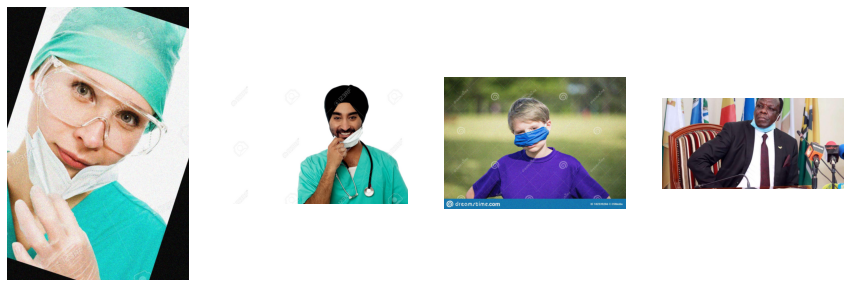

In [21]:
fig=plt.figure(figsize=(15, 10))
axes = []
for i in range(4):
    img = cv.cvtColor(incorrect[i], cv.COLOR_BGR2RGB)
    axes.append(fig.add_subplot(1, 4, i+1))
    plt.axis('off')
    plt.imshow(img)   
plt.show()

That is not good. The images have watermarks and may be rotated.

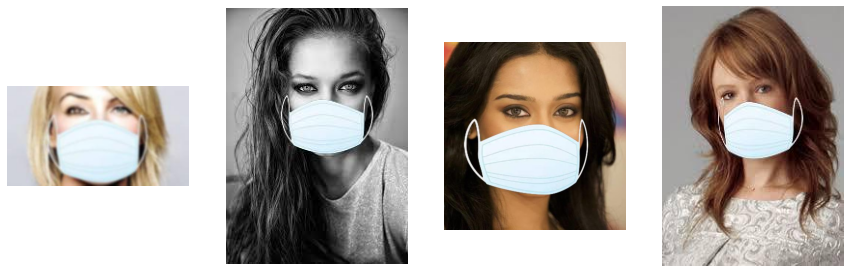

In [22]:
fig=plt.figure(figsize=(15, 10))
axes = []
for i in range(4):
    img = cv.cvtColor(masked[i], cv.COLOR_BGR2RGB)
    axes.append(fig.add_subplot(1, 4, i+1))
    plt.axis('off')
    plt.imshow(img)   
plt.show()

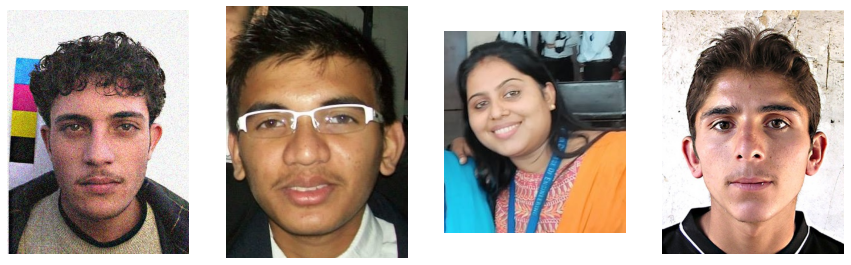

In [23]:
fig=plt.figure(figsize=(15, 10))
axes = []
for i in range(4):
    img = cv.cvtColor(unmasked[i], cv.COLOR_BGR2RGB)
    axes.append(fig.add_subplot(1, 4, i+1))
    plt.axis('off')
    plt.imshow(img)   
plt.show()

## Detect faces

In this implementation I will use OpenCV's Haar Cascades.

In [32]:
face_detector = cv.CascadeClassifier('models/haarcascade_frontalface_default.xml')

To use this model, I have to convert my images into the greyscale.

The detector may detect multiple faces in the picture. I shall use them all in the next steps.

In [49]:
show_detected = [unmasked[0], masked[0], incorrect[0], unmasked[1], masked[1], incorrect[1]]

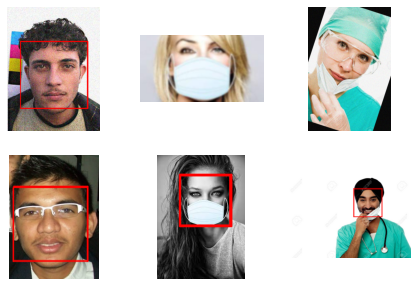

In [60]:
fig=plt.figure(figsize=(7.5, 5))
axes = []
for i in range(len(show_detected)):
    img_display = show_detected[i]
    img = cv.cvtColor(img_display, cv.COLOR_BGR2GRAY)
    faces = face_detector.detectMultiScale(img, scaleFactor = 1.2, minNeighbors = 5)
    for (a, b, c, d) in faces:
        cv.rectangle(img_display, (a, b), (a+c, b+d), (0, 0, 255), 2)
    img = cv.cvtColor(img_display, cv.COLOR_BGR2RGB)
    axes.append(fig.add_subplot(2, 3, i+1))
    plt.axis('off')
    plt.imshow(img)   
plt.show()

In [57]:
print(len(masked))
print(len(unmasked))
print(len(incorrect))

690
686
685


The detected faces could be of different sizes - I need to rescale them before feeding them into another classifier.

In [61]:
def get_faces(img, model, scaleFactor=1.2, 
              minNeighbors=5, dimensions=(240, 240), for_display=False):
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    faces = model.detectMultiScale(img_gray, scaleFactor = scaleFactor, 
                                   minNeighbors = minNeighbors)
    extracted = []
    coords = []
    for (a, b, c, d) in faces:
        crop_img = img_gray[b:b+d, a:a+c]
        if crop_img.size != 0 and crop_img.size != 1:
            crop_img = cv.resize(crop_img, dimensions)
            extracted.append(crop_img)
    if len(extracted) == 0:
        return None
    if for_display:
        return extracted, faces
    return extracted

In [77]:
mfaces = [get_faces(image, face_detector) for image in masked]
mfaces = [face for image in mfaces if image is not None for face in image]

ufaces = [get_faces(image, face_detector) for image in unmasked]
ufaces = [face for image in ufaces if image is not None for face in image]

ifaces = [get_faces(image, face_detector) for image in incorrect]
ifaces = [face for image in ifaces if image is not None for face in image]

In [78]:
print(len(mfaces))
print(len(ufaces))
print(len(ifaces))

297
606
421


As we can see, the used face detector didn't work very well. It will most definitely hinder model's overall performance.

I should prepare the labels for the data.

## Prepare the data

In [85]:
mfaces_lbl = [2]* len(mfaces)
ifaces_lbl = [1]* len(ifaces)
ufaces_lbl = [0]* len(ufaces)
y = mfaces_lbl + ifaces_lbl + ufaces_lbl

In [102]:
 x= np.concatenate((mfaces, ifaces, ufaces))

And flatten the data for the classifier.

In [104]:
x = (np.array(x)).reshape(len(y), -1)

In [107]:
from sklearn.model_selection import train_test_split

In [108]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, 
                                                    random_state=1, stratify=y)

## Train the classifier

In [109]:
from sklearn.ensemble import RandomForestClassifier

In [110]:
mask_detector = RandomForestClassifier().fit(X_train, y_train)

In [111]:
mask_detector.score(X_test, y_test)

0.9169811320754717

## Let's see the application results

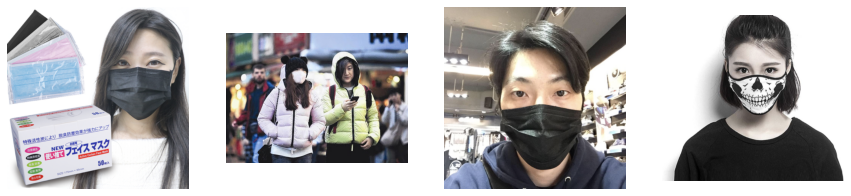

In [130]:
img1 = cv.imread("dataset/other.png")
img2 = cv.imread("dataset/other_example.png")
img3 = cv.imread("dataset/second_approach/images/maksssksksss195.png")
img4 = cv.imread("dataset/second_approach/images/maksssksksss211.png")
test_imgs = [img1, img2, img3, img4]
fig=plt.figure(figsize=(15, 10))
axes = []
for i in range(4):
    img = cv.cvtColor(test_imgs[i], cv.COLOR_BGR2RGB)
    axes.append(fig.add_subplot(1, 4, i+1))
    plt.axis('off')
    plt.imshow(img)   
plt.show()

In [121]:
mask_result = ["No mask!", "Incorrect!", "Mask"]
mask_coloring = [(255, 0, 0), (255, 0, 0), (0, 255, 0)]

In [122]:
mask_coloring = [(255, 0, 0), (255, 0, 0), (0, 255, 0)]

In [123]:
font = cv.FONT_HERSHEY_SIMPLEX

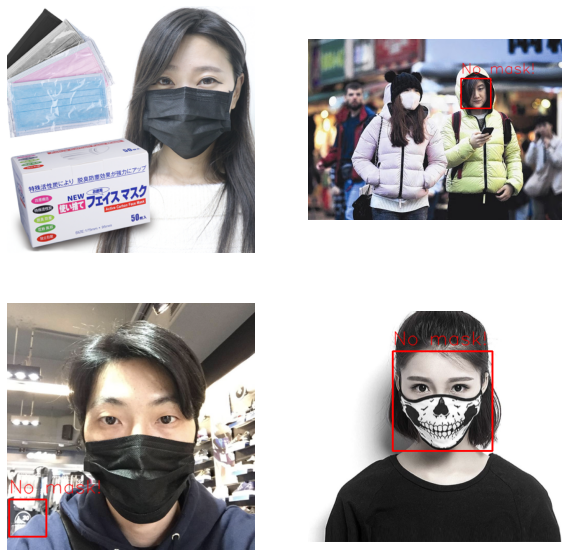

In [138]:
fig=plt.figure(figsize=(10,10))
axes = []
for i in range(4):
    img = test_imgs[i]
    if get_faces(img, face_detector) is not None:
        faces, coords = get_faces(img, face_detector, for_display=True)
        faces = [face for image in faces for face in image]
        faces_flattened = (np.array(faces)).reshape((len(coords), -1))
        res = mask_detector.predict(faces_flattened)
        img_display = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        j = 0
        for coord in coords:
            cv.rectangle(img_display, (coord[0], coord[1]), (coord[0]+coord[2], coord[1]+coord[3]), mask_coloring[res[j]], 2)
            cv.putText(img_display,mask_result[res[j]],(coord[0], coord[1]-10), fontFace = font, fontScale=1, color=mask_coloring[res[j]],thickness=1, lineType=cv.LINE_AA)
            j += 1
    else:
        img_display = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    axes.append(fig.add_subplot(2, 2, i+1))
    plt.axis('off')
    plt.imshow(img_display) 
plt.show()

# Approach 2

## Change of face detector

In [139]:
face_detector = cv.dnn.readNetFromCaffe("models/deploy.prototxt.txt", "models/res10_300x300_ssd_iter_140000.caffemodel")

In [140]:
def get_faces(img, model, dimensions=(240, 240), for_display=False):
    h, w = img.shape[:2]
    blob = cv.dnn.blobFromImage(cv.resize(img, (300, 300)), 1.0, (300, 300), (104.0, 117.0, 123.0))
    model.setInput(blob)
    detected = model.forward()
    extracted = []
    coordinates = []
    for i in range(detected.shape[2]):
        confidence = detected[0, 0, i, 2]
        if confidence > 0.5:
            box = detected[0, 0, i, 3:7] * np.array([w, h, w, h])
            coords = box.astype("int")
            crop_img = img[coords[1]:coords[3], coords[0]:coords[2]]
            crop_img = cv.resize(crop_img, dimensions)
            crop_img = cv.cvtColor(crop_img, cv.COLOR_BGR2GRAY)
            extracted.append(crop_img)
            if for_display:
                coordinates.append(coords)
    if len(extracted)==0:
        return None
    if for_display:
        return extracted, coordinates
    return extracted

In [142]:
mfaces = [get_faces(image, face_detector) for image in masked]
mfaces = [face for image in mfaces if image is not None for face in image]

ufaces = [get_faces(image, face_detector) for image in unmasked]
ufaces = [face for image in ufaces if image is not None for face in image]

ifaces = [get_faces(image, face_detector) for image in incorrect]
ifaces = [face for image in ifaces if image is not None for face in image]

In [143]:
print(len(mfaces))
print(len(ufaces))
print(len(ifaces))

695
722
645


In [154]:
mfaces1 = [get_faces(image, face_detector) for image in masked]
mfaces1 = [i for i in mfaces1 if i is not None]
ufaces1 = [get_faces(image, face_detector) for image in unmasked]
ufaces1 = [i for i in ufaces1 if i is not None]
ifaces1= [get_faces(image, face_detector) for image in incorrect]
ifaces1 = [i for i in ifaces1 if i is not None]

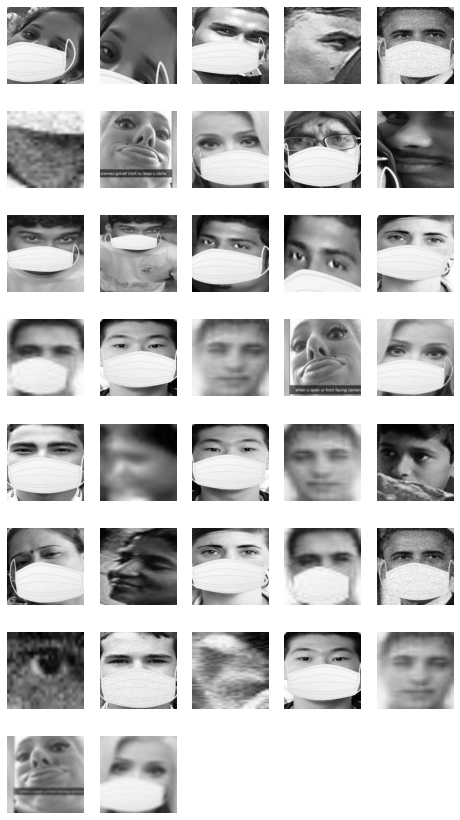

In [193]:
fig=plt.figure(figsize=(8, 15))
axes = []
j = 0
for i in range(len(mfaces1)):
    if (len(mfaces1[i]) != 1):
        for face in mfaces1[i]:
            img = cv.cvtColor(face, cv.COLOR_BGR2RGB)
            axes.append(fig.add_subplot(8, 5, j+1))
            plt.axis('off')
            plt.imshow(img)
            j += 1
        
plt.show()

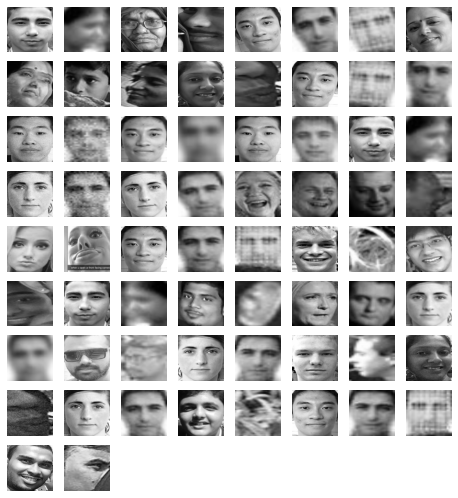

In [194]:
fig=plt.figure(figsize=(8,20))
axes = []
j = 0
for i in range(len(ufaces1)):
    if (len(ufaces1[i]) != 1):
        for face in ufaces1[i]:
            img = cv.cvtColor(face, cv.COLOR_BGR2RGB)
            axes.append(fig.add_subplot(20, 8, j+1))
            plt.axis('off')
            plt.imshow(img)
            j += 1
        
plt.show()

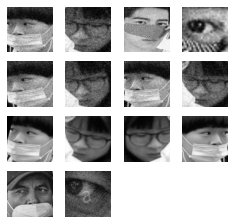

In [187]:
fig=plt.figure(figsize=(4,20))
axes = []
j = 0
for i in range(len(ifaces1)):
    if (len(ifaces1[i]) != 1):
        for face in ifaces1[i]:
            img = cv.cvtColor(face, cv.COLOR_BGR2RGB)
            axes.append(fig.add_subplot(20, 4, j+1))
            plt.axis('off')
            plt.imshow(img)
            j += 1
        
plt.show()

## Change of dataset